In [1]:
from os import path
import sys
if path.expanduser('~/projects/stellarstreams/') not in sys.path:
    sys.path.append(path.expanduser('~/projects/stellarstreams/'))

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits, ascii
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.optimize import minimize

import emcee
from pyia import GaiaData
#import schwimmbad

import gala.coordinates as gc
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.mpl_style import center_emph

In [2]:
mw = gp.MilkyWayPotential()
galcen_frame = coord.Galactocentric(galcen_distance=8.1*u.kpc)

In [3]:
rrl = Table.read('../data/pal5/RRL-with-prob.fits')
rrl = rrl[(rrl['member_prob'] > 0.5) & rrl['inside_stream_track']]

rgb = Table.read('../data/pal5/rgb_rough_mask.fits')
for col in rrl.colnames:
    if col in rgb.colnames and rgb[col].dtype != rrl[col].dtype:
        try:
            rrl[col] = rrl[col].astype(rgb[col].dtype)
        except:
            print(col)
            rrl.remove_column(col)

tbl = vstack((rrl, rgb))
g = GaiaData(tbl)

g.data['D_ps1'][tbl['D_ps1'] == 0] = 1.
g.data['vhelio'][tbl['vhelio'] == 0] = -12345

epoch_photometry_url


In [4]:
c_icrs = g.get_skycoord(distance=g.D_ps1 * u.kpc, 
                        radial_velocity=g.vhelio * u.km/u.s)
c = c_icrs.transform_to(gc.Pal5PriceWhelan18)

D_err = 0.04 * g.D_ps1
rv_err = g.vhelio_err

In [5]:
C_icrs = g.get_cov()
C = gc.transform_pm_cov(c_icrs, C_icrs[:, 3:5, 3:5], gc.Pal5PriceWhelan18)
pm1_err = np.sqrt(C[:, 0, 0])
pm2_err = np.sqrt(C[:, 1, 1])

(-80, -30)

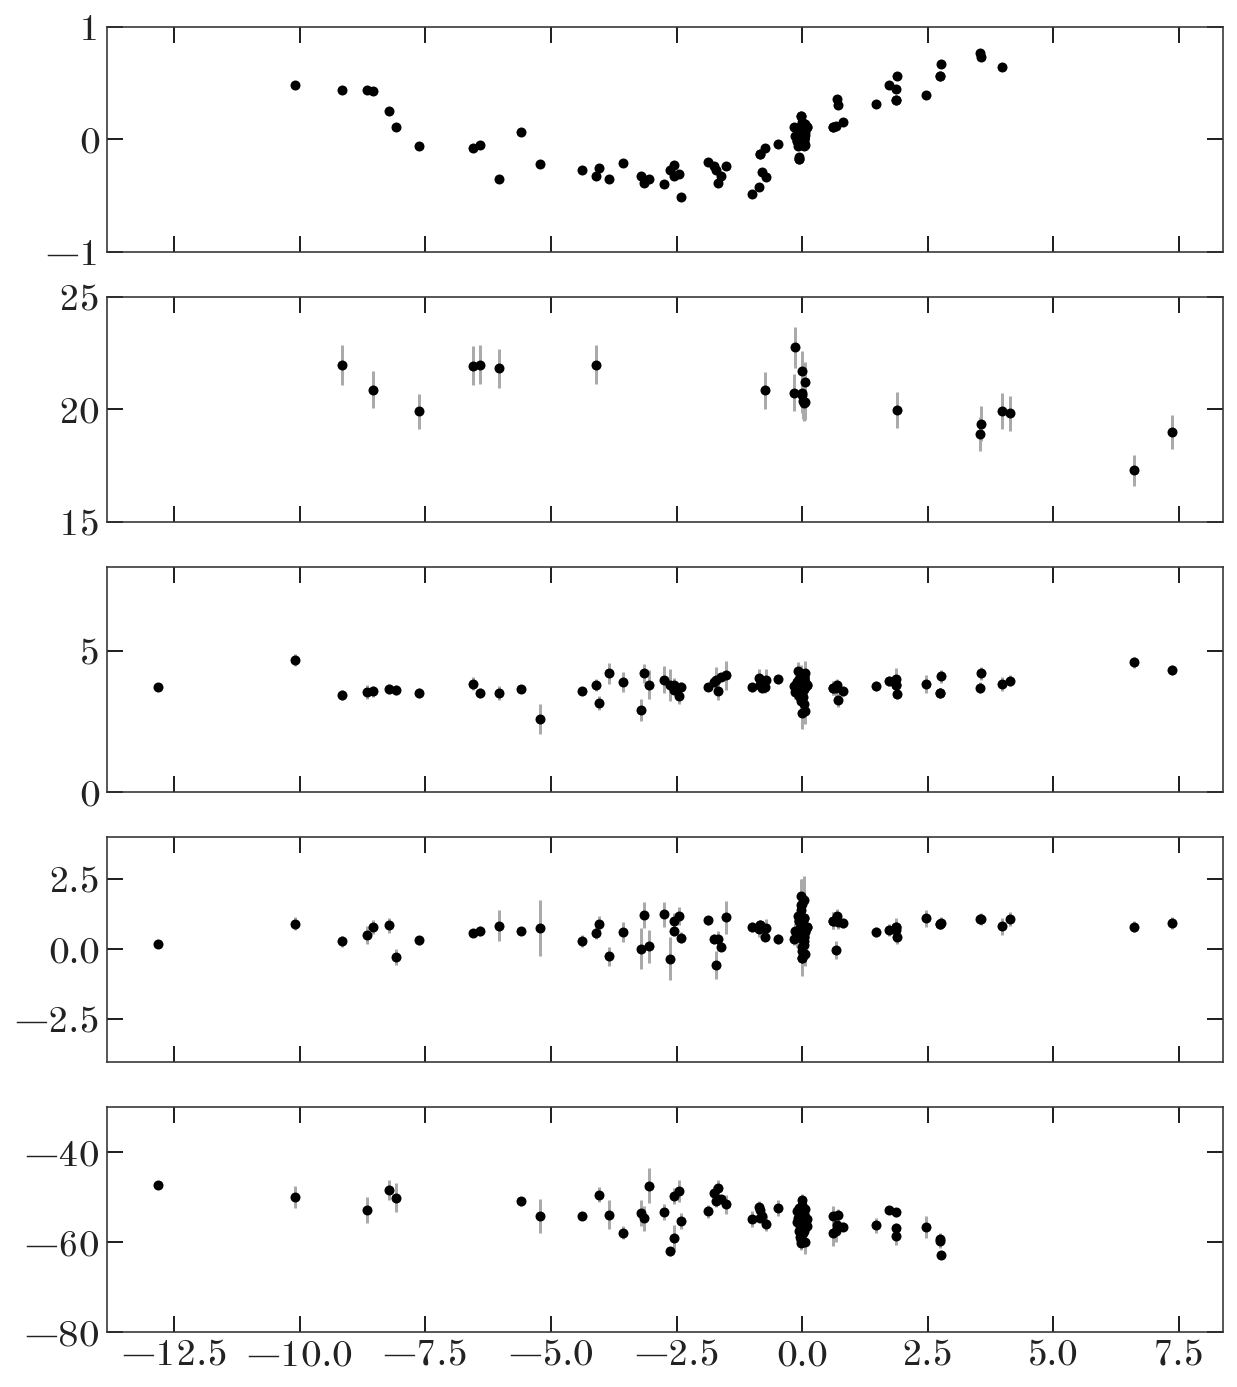

In [6]:
style = dict(marker='o', color='k', ls='none', ecolor='#aaaaaa')

fig, axes = plt.subplots(5, 1, figsize=(10, 12), 
                         sharex=True)

axes[0].errorbar(c.phi1.value, 
                 c.phi2.degree, **style)
axes[0].set_ylim(-1, 1)

axes[1].errorbar(c.phi1.value, c.distance.value, 
                 yerr=D_err, **style)
axes[1].set_ylim(15, 25)

axes[2].errorbar(c.phi1.value, c.pm_phi1_cosphi2.value, 
                 yerr=pm1_err, **style)
axes[2].set_ylim(0, 8)

axes[3].errorbar(c.phi1.value, c.pm_phi2.value,
                 yerr=pm2_err, **style)
axes[3].set_ylim(-4, 4)

axes[4].errorbar(c.phi1.value, c.radial_velocity.value, 
                 yerr=rv_err, **style)
axes[4].set_ylim(-80, -30)

In [7]:
pal5_c = coord.SkyCoord(ra=229.018*u.degree, dec=-0.124*u.degree)
cl_mask = c_icrs.separation(pal5_c) < 15*u.arcmin

cl_c = coord.SkyCoord(phi1=0*u.degree, phi2=0*u.degree,
                      distance=20.9*u.kpc,
                      pm_phi1_cosphi2=c.pm_phi1_cosphi2[cl_mask].mean(),
                      pm_phi2=c.pm_phi2[cl_mask].mean(),
                      radial_velocity=c.radial_velocity[cl_mask & (c.radial_velocity>-1000*u.km/u.s)].mean(),
                      frame=gc.Pal5)

In [8]:
w0 = gd.PhaseSpacePosition(cl_c.transform_to(galcen_frame).data)

In [9]:
df = ms.FardalStreamDF()

pal5_pot = gp.PlummerPotential(m=1.5e4*u.Msun, b=5*u.pc, 
                               units=galactic)
gen = ms.MockStreamGenerator(df, mw,
                             progenitor_potential=pal5_pot)

stream, _ = gen.run(w0, 2e4*u.Msun,
                    dt=-1 * u.Myr, n_steps=6000,
                    release_every=16)

stream_c = stream.to_coord_frame(gc.Pal5, 
                                 galactocentric_frame=galcen_frame)

(-80, -30)

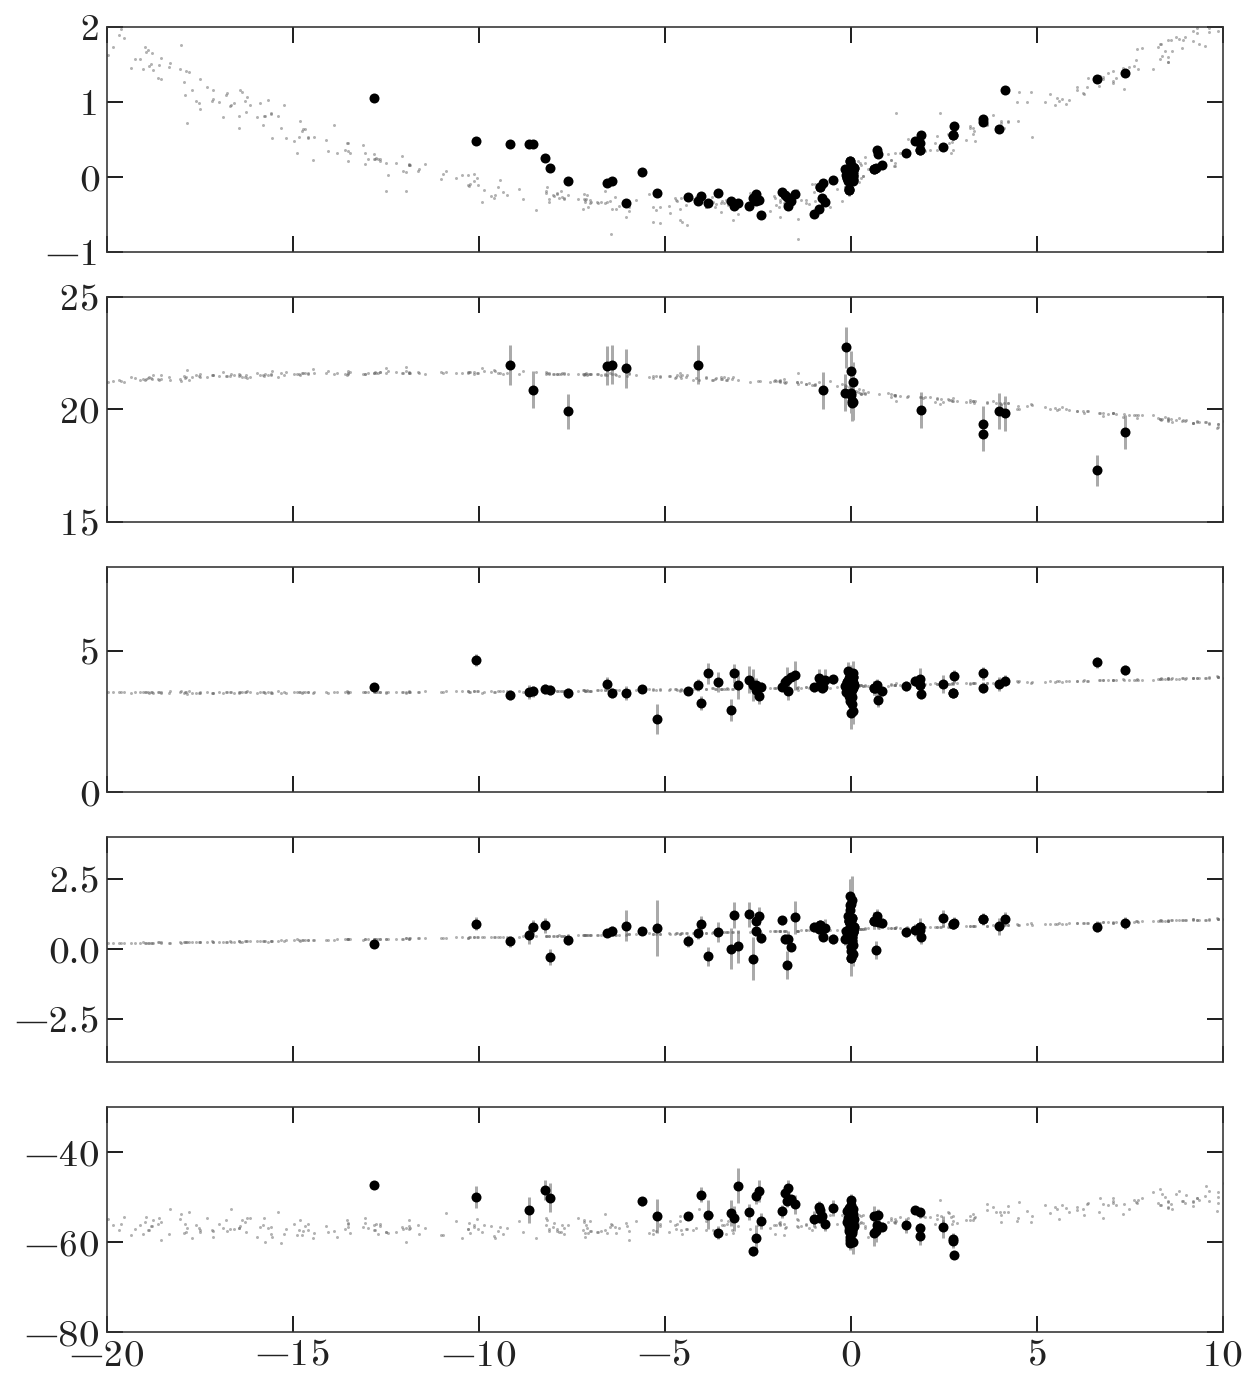

In [10]:
sstyle = dict(marker='o', ls='none', ms=1.5, 
              color='#666666', alpha=0.5)

fig, axes = plt.subplots(5, 1, figsize=(10, 12), 
                         sharex=True)

axes[0].errorbar(c.phi1.value, 
                 c.phi2.degree, **style)
axes[0].plot(stream_c.phi1.degree, stream_c.phi2.degree, **sstyle)
axes[0].set_ylim(-1, 2)
axes[0].set_xlim(-20, 10)

axes[1].errorbar(c.phi1.value, c.distance.value, 
                 yerr=D_err, **style)
axes[1].plot(stream_c.phi1.degree, stream_c.distance.value, **sstyle)
axes[1].set_ylim(15, 25)

axes[2].errorbar(c.phi1.value, c.pm_phi1_cosphi2.value, 
                 yerr=pm1_err, **style)
axes[2].plot(stream_c.phi1.degree, stream_c.pm_phi1_cosphi2.value, **sstyle)
axes[2].set_ylim(0, 8)

axes[3].errorbar(c.phi1.value, c.pm_phi2.value,
                 yerr=pm2_err, **style)
axes[3].plot(stream_c.phi1.degree, stream_c.pm_phi2.value, **sstyle)
axes[3].set_ylim(-4, 4)

axes[4].errorbar(c.phi1.value, c.radial_velocity.value, 
                 yerr=rv_err, **style)
axes[4].plot(stream_c.phi1.degree, stream_c.radial_velocity.value, **sstyle)
axes[4].set_ylim(-80, -30)

In [33]:
data = Table()

data['phi1'] = c.phi1
data['phi1_ivar'] = 1 / (1*u.mas).to(u.deg)**2

data['phi2'] = c.phi2
data['phi2_ivar'] = 1 / (1*u.mas).to(u.deg)**2

data['distance'] = c.distance
data['distance'][data['distance'] < 15] = np.nan
data['distance_ivar'] = 1 / (D_err * u.kpc)**2

data['pm_phi1_cosphi2'] = c.pm_phi1_cosphi2
data['pm_phi1_cosphi2_ivar'] = 1 / (pm1_err * u.mas/u.yr)**2 

data['pm_phi2'] = c.pm_phi2
data['pm_phi2_ivar'] = 1 / (pm2_err * u.mas/u.yr)**2

data['radial_velocity'] = c.radial_velocity
data['radial_velocity_ivar'] = 1 / (rv_err * u.km/u.s)**2
data['radial_velocity'][data['radial_velocity'] < -100] = np.nan

/Users/apricewhelan/anaconda/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


---

In [67]:
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.stats import binned_statistic

def get_stream_track(stream_c, frame_comp_names,
                     phi1_lim=[-180, 180]*u.deg,
                     phi1_bins=None, phi1_binsize=1*u.deg,
                     units=None):

    # All position and velocity component names:
#     component_names = (
#         list(stream_c.get_representation_component_names().keys()) +
#         list(stream_c.get_representation_component_names('s').keys()))

    # If no units are provided:
    if units is None:
        units = dict()

    units['phi1'] = units.get('phi1',
                              getattr(stream_c, frame_comp_names[0]).unit)

    phi1 = stream_c.spherical.lon.wrap_at(180*u.deg).to_value(units['phi1'])
    phi1_lim = phi1_lim.to_value(units['phi1'])
    
    if phi1_bins is None:
        phi1_binsize = phi1_binsize.to_value(units['phi1'])
        phi1_bins = np.arange(phi1_lim[0], phi1_lim[1]+1e-8, phi1_binsize)
    
    # HACK:
    #phi1_bins = np.concatenate((np.arange(phi1_lim[0], -1, phi1_binsize),
    #                            np.arange(-1, 1, phi1_binsize/8),
    #                            np.arange(1, phi1_lim[1], phi1_binsize)))
    phi1_binc = 0.5 * (phi1_bins[:-1] + phi1_bins[1:])

    means = dict()
    stds = dict()
    mean_tracks = dict()
    std_tracks = dict()

    for k in frame_comp_names[1:]:
        val = getattr(stream_c, k)
        if k in units:
            val = val.to_value(units[k])
        else:
            units[k] = val.unit
            val = val.value

        means[k] = binned_statistic(phi1, val,
                                    bins=phi1_bins, statistic='mean')
        stds[k] = binned_statistic(phi1, val,
                                   bins=phi1_bins, statistic='std')

        mask = np.isfinite(means[k].statistic)
        mean_tracks[k] = InterpolatedUnivariateSpline(phi1_binc[mask],
                                                      means[k].statistic[mask])
        mask = np.isfinite(stds[k].statistic)
        std_tracks[k] = InterpolatedUnivariateSpline(phi1_binc[mask],
                                                     stds[k].statistic[mask])

    return mean_tracks, std_tracks

In [68]:
def ln_normal(x, mu, std):
    return -0.5 * (x-mu)**2 / std**2 - 0.5*np.log(2*np.pi) - np.log(std)

def ln_normal_ivar(x, mu, ivar):
    return -0.5 * (x-mu)**2 * ivar - 0.5*np.log(2*np.pi) + 0.5*np.log(ivar)

def get_ivar(ivar, extra_var):
    return ivar / (1 + extra_var * ivar)

In [84]:
def make_phi1_bins(max_w=1., min_w=0.2, 
                   max_phi1=20,
                   lim=[-20, 15]):
    pt1 = (0, min_w)
    pt2 = (max_phi1, max_w)
    
    x = lim[0]
    bin_edges = [x]
    for n in range(1000):  # finite N iterations
        w = (pt2[1]-pt1[1]) / (pt2[0]-pt1[0]) * np.abs(x - pt1[0]) + pt1[1]
        x += w
        bin_edges.append(x)
        
        if x >= lim[1]:
            break
            
    else:
        raise ValueError()
    
    return np.array(bin_edges)

phi1_lim = [-22, 12]*u.deg
phi1_bins = make_phi1_bins(max_w=2, min_w=0.5, lim=phi1_lim.value)

In [85]:
pal5_pot = gp.PlummerPotential(m=1.5e4*u.Msun, b=5*u.pc, 
                               units=galactic)

def ln_likelihood(p, phi1, pot, data, data_units, frame_comp_names, extra_var, plot=False):
    phi2, dist, pm1, pm2, rv, *other_p = p
    lnMhalo, halo_c, lnMdisk = other_p
    
    # M_pal5 = np.exp(lnM)
    # if not 8e3 < M_pal5 < 4e5:
    #     return -np.inf
    
    if not 25 < lnMhalo < 29:
        return -np.inf
    if not 0.8 < halo_c < 1.2:
        return -np.inf
    
    if not 23 < lnMdisk < 28:
        return -np.inf
    
    pot = gp.MilkyWayPotential(halo=dict(m=np.exp(lnMhalo), c=halo_c),
                               disk=dict(m=np.exp(lnMdisk)))
    
    # galcen_frame = coord.Galactocentric(galcen_distance=8.1*u.kpc,
    #                                     galcen_v_sun=coord.CartesianDifferential([vx, vy, vz]*u.km/u.s))
    
    c = gc.Pal5PriceWhelan18(phi1=phi1, phi2=phi2*data_units['phi2'],
                             distance=dist*u.kpc,
                             pm_phi1_cosphi2=pm1*u.mas/u.yr,
                             pm_phi2=pm2*u.mas/u.yr,
                             radial_velocity=rv*u.km/u.s)
    w0 = gd.PhaseSpacePosition(c.transform_to(galcen_frame).data)
    
    # Integrate the orbit and generate the stream - set these parameters!:
    gen = ms.MockStreamGenerator(df, mw,
                                 progenitor_potential=pal5_pot)

    stream, _ = gen.run(w0, 2e4*u.Msun,
                        dt=-1 * u.Myr, n_steps=3000,
                        release_every=2)
    stream_c = stream.to_coord_frame(gc.Pal5PriceWhelan18, 
                                     galactocentric_frame=galcen_frame)
    
    tracks, stds = get_stream_track(stream_c, frame_comp_names,
                                    phi1_bins=phi1_bins,
                                    phi1_lim=phi1_lim,
                                    # phi1_binsize=1.5*u.deg,
                                    units=data_units)
    
    if plot:
        fig, axes = plt.subplots(5, 1, figsize=(8, 12), 
                                 sharex=True)

        grid = np.linspace(phi1_lim[0].value, phi1_lim[1].value, 1024)
        for i, name in enumerate(frame_comp_names[1:]):
            ax = axes[i]

            ax.plot(data['phi1'][data[name]!=0], data[name][data[name]!=0], 
                    marker='o', ls='none', color='k', ms=4)

            ax.plot(stream_c.phi1.wrap_at(180*u.deg).degree,
                    getattr(stream_c, name).value, 
                    marker='o', ls='none', color='tab:blue', ms=2, alpha=0.4, zorder=-100)

            ax.plot(grid, tracks[name](grid), marker='', color='tab:orange', alpha=0.5)

            ax.set_ylabel(name, fontsize=12)

        ax.set_xlim(phi1_lim.value)
        axes[0].set_ylim(-1.5, 3)
        axes[1].set_ylim(15, 25)
        axes[2].set_ylim(2, 5.5)
        axes[3].set_ylim(-1, 2)
        axes[4].set_ylim(-75, -20)
        fig.tight_layout()
        fig.set_facecolor('w')
        
        # -- residuals --
        fig, axes = plt.subplots(5, 1, figsize=(8, 12), 
                                 sharex=True)

        grid = np.linspace(phi1_lim[0].value, phi1_lim[1].value, 1024)
        for i, name in enumerate(frame_comp_names[1:]):
            ax = axes[i]
            
            ivar = get_ivar(data[name+'_ivar'],
                            extra_var[name]) 
            ax.errorbar(data['phi1'][ivar > 0.], 
                        data[name][ivar > 0] - tracks[name](data['phi1'][ivar > 0.]),
                        yerr=1/np.sqrt(ivar[ivar > 0.]), 
                        marker='o', ls='none', color='k', ecolor='#aaaaaa')
            ax.axhline(0.)
            ax.set_ylabel(name, fontsize=12)

        ax.set_xlim(phi1_lim.value)
        axes[0].set_ylim(-1, 1)
        axes[1].set_ylim(-4, 4)
        axes[2].set_ylim(-2, 2)
        axes[3].set_ylim(-2, 2)
        axes[4].set_ylim(-10, 10)
        axes[0].set_title('Residuals')
        fig.tight_layout()
        fig.set_facecolor('w')
    
    lls = []
    for name in frame_comp_names[1:]: # skip phi1
        ivar = get_ivar(data[name+'_ivar'],
                        stds[name](data['phi1'])**2 + extra_var[name])
        ll = ln_normal_ivar(tracks[name](data['phi1']),
                            data[name], ivar)
        ll[~np.isfinite(ll)] = np.nan
        lls.append(ll)

    return np.nansum(lls, axis=0).sum()

def neg_ln_likelihood(*args, **kwargs):
    return -ln_likelihood(*args, **kwargs)

In [86]:
p0 = [cl_c.phi2.degree,
      cl_c.distance.kpc,
      cl_c.pm_phi1_cosphi2.value,
      cl_c.pm_phi2.value,
      cl_c.radial_velocity.value,
      np.log(mw['halo'].parameters['m'].value), 1,
      np.log(mw['disk'].parameters['m'].value)] 
# 11.1, 232.24, 7.25,

data_units = {'phi1': u.deg, 'phi2': u.deg, 'distance': u.kpc,
              'pm_phi1_cosphi2': u.mas/u.yr, 'pm_phi2': u.mas/u.yr,
              'radial_velocity': u.km/u.s}

extra_var = dict()
extra_var['phi2'] = (0.02 * u.deg)**2
extra_var['distance'] = (1. * u.kpc)**2
extra_var['pm_phi1_cosphi2'] = (0.25 * u.mas/u.yr)**2
extra_var['pm_phi2'] = (0.25 * u.mas/u.yr)**2
extra_var['radial_velocity'] = (5 * u.km/u.s)**2

frame_comp_names = (
    list(cl_c.get_representation_component_names().keys()) +
    list(cl_c.get_representation_component_names('s').keys()))

_extra_var = dict()
for k in extra_var:
    _extra_var[k] = extra_var[k].to_value(data_units[k]**2)

args = (cl_c.phi1, mw, data, data_units, frame_comp_names, _extra_var)

/Users/apricewhelan/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


-422.7453348730402

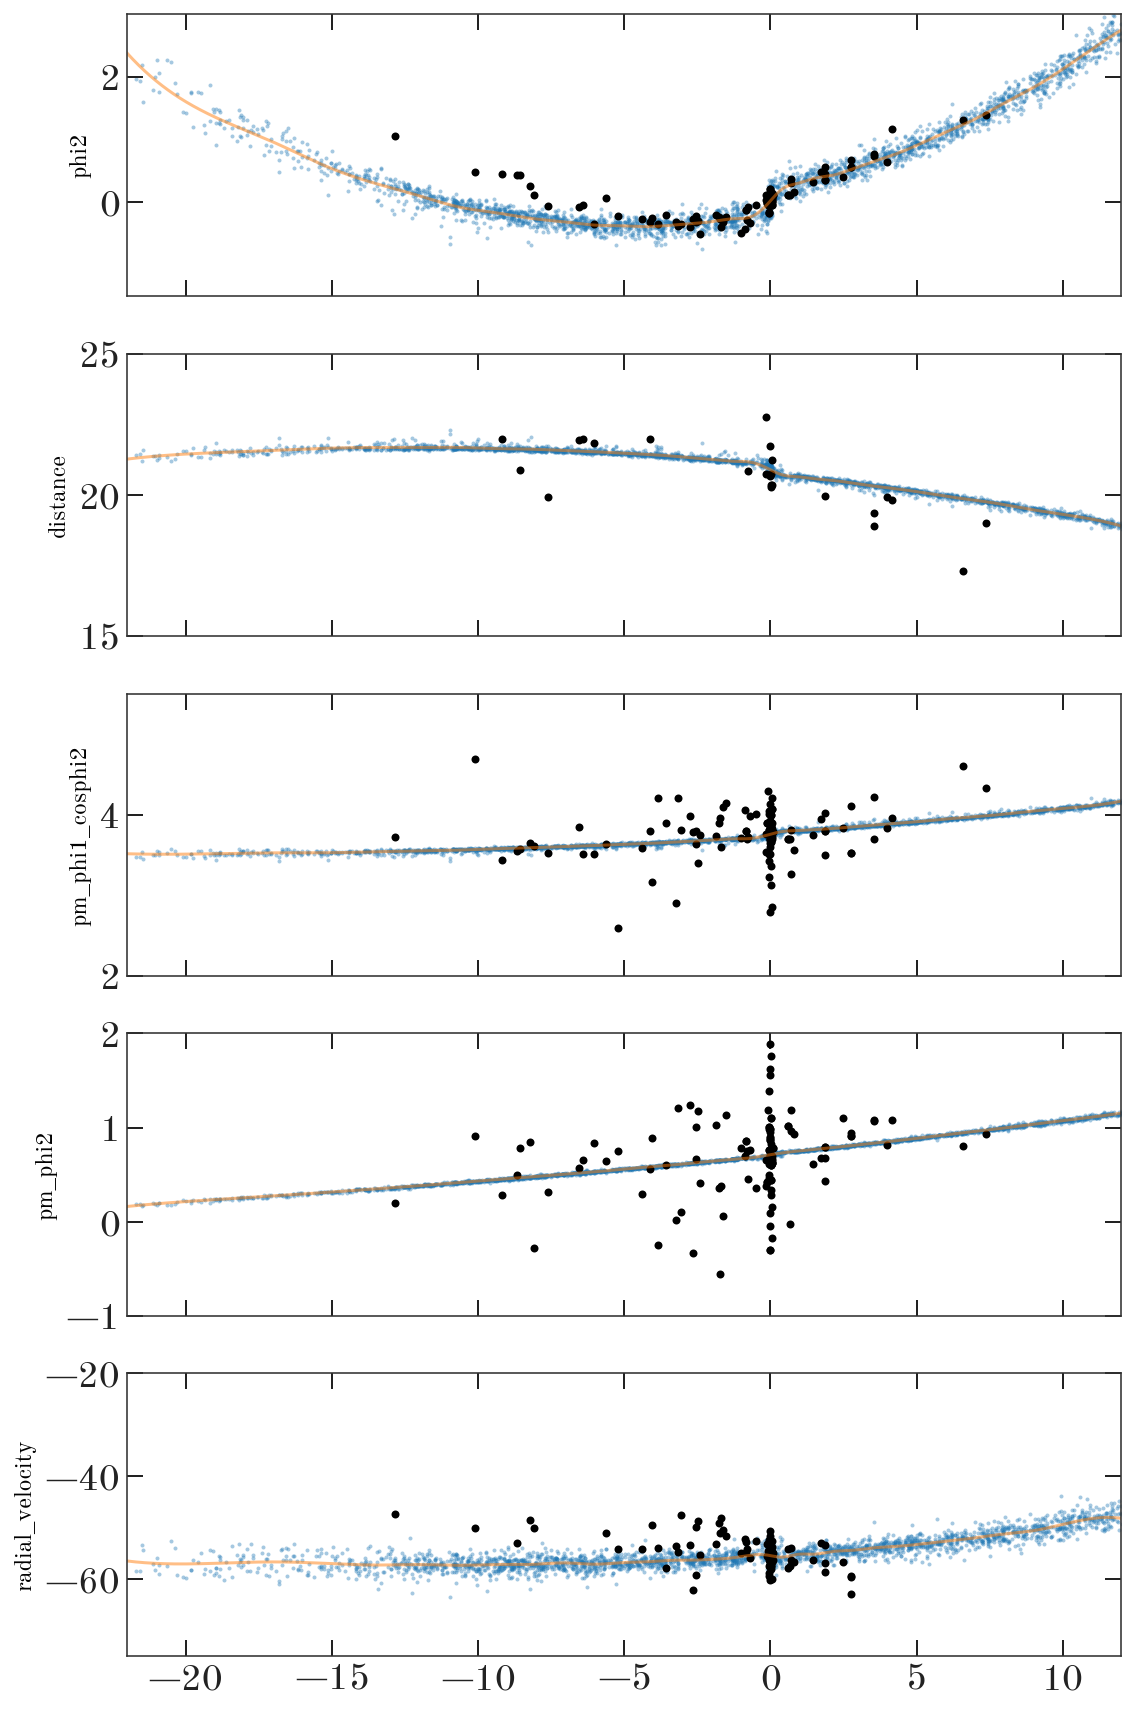

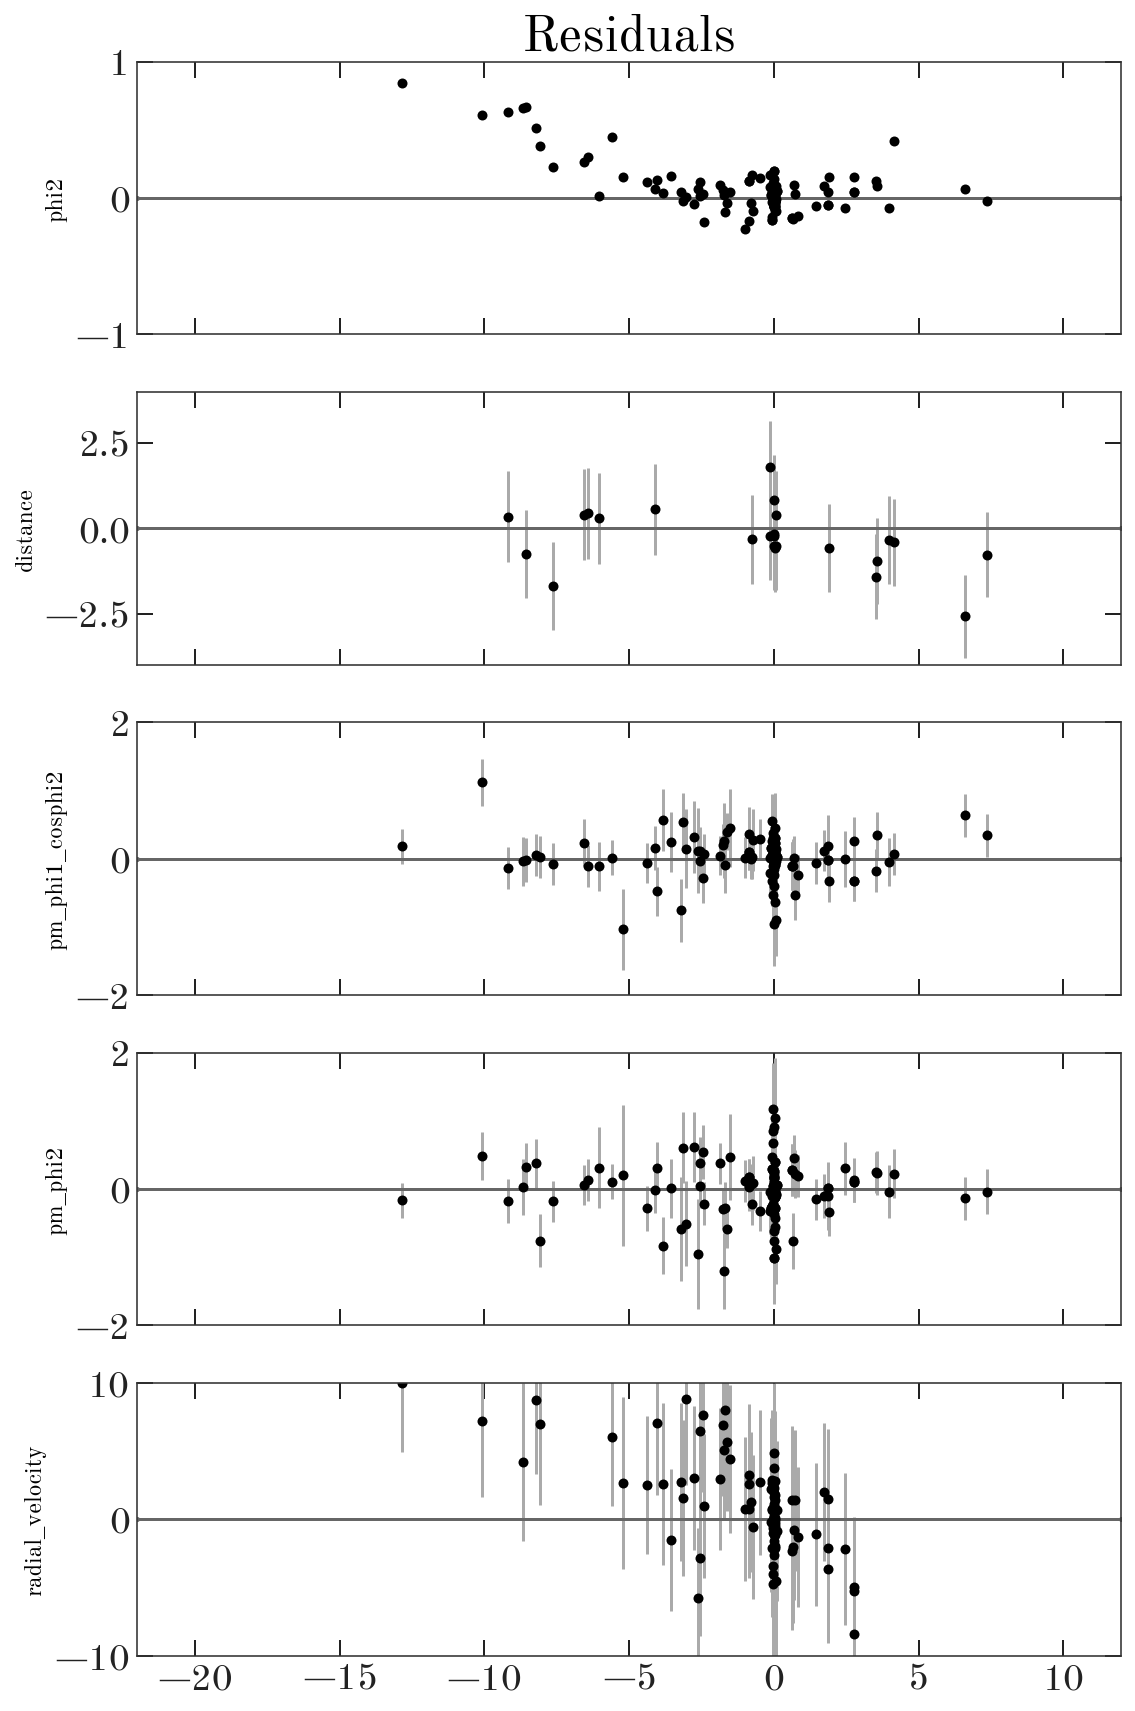

In [87]:
ln_likelihood(p0, *args, plot=True)

In [60]:
%%time
# res = minimize(neg_ln_likelihood, x0=p0, args=args,
#                method='L-BFGS-B',
#                bounds=[(-0.1, 0.1), (20, 35), (None, None), (-1, 1), (-70, -40),
#                        (0, 20), (220, 260), (0, 15)])
res = minimize(neg_ln_likelihood, x0=p0, args=args,
               method='powell')

/Users/apricewhelan/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/Users/apricewhelan/anaconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/apricewhelan/anaconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/apricewhelan/anaconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2315: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


CPU times: user 8min 58s, sys: 929 ms, total: 8min 59s
Wall time: 8min 59s


In [61]:
res

   direc: array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])
     fun: 291.1398722415376
 message: 'Optimization terminated successfully.'
    nfev: 355
     nit: 3
  status: 0
 success: True
       x: array([ 3.64098650e-02,  1.97559733e+01,  3.83442589e+00,  6.92904214e-01,
       -5.58127521e+01,  2.76771005e+01,  1.11980719e+00,  2.49729735e+01])

/Users/apricewhelan/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/Users/apricewhelan/anaconda/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


-296.902354168607

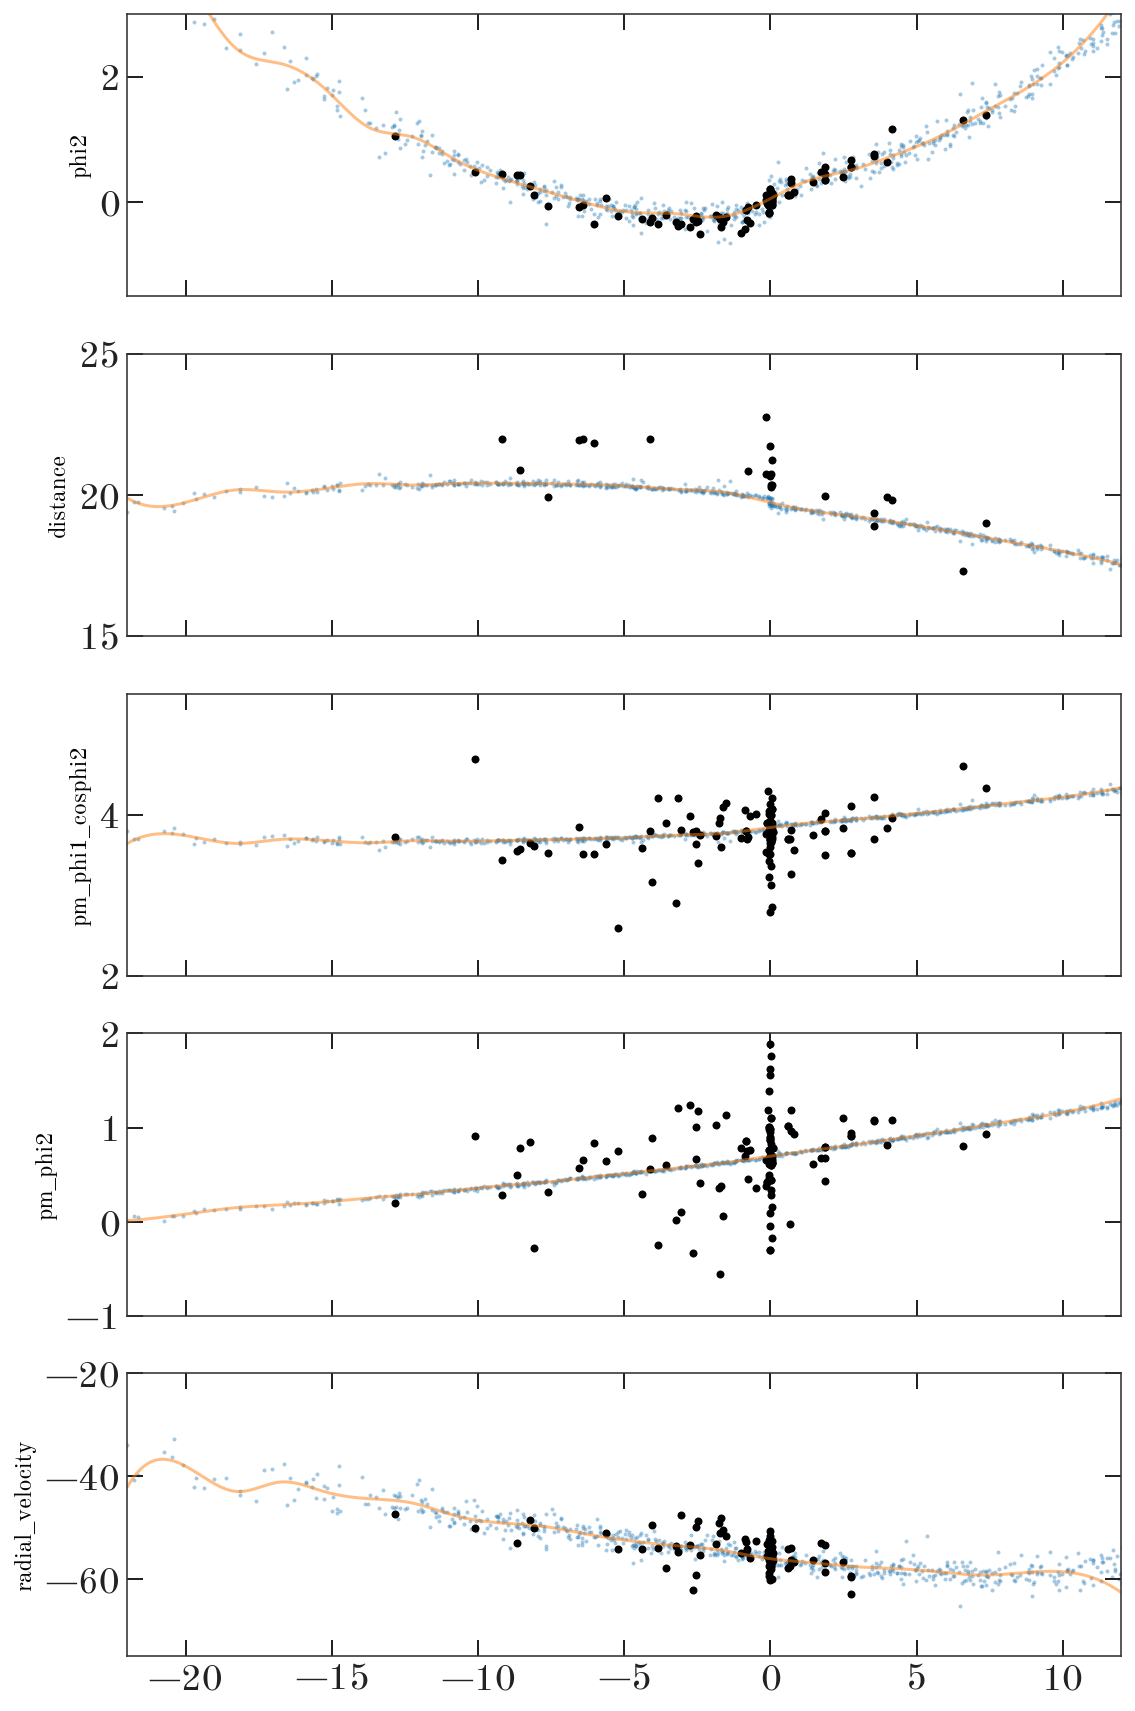

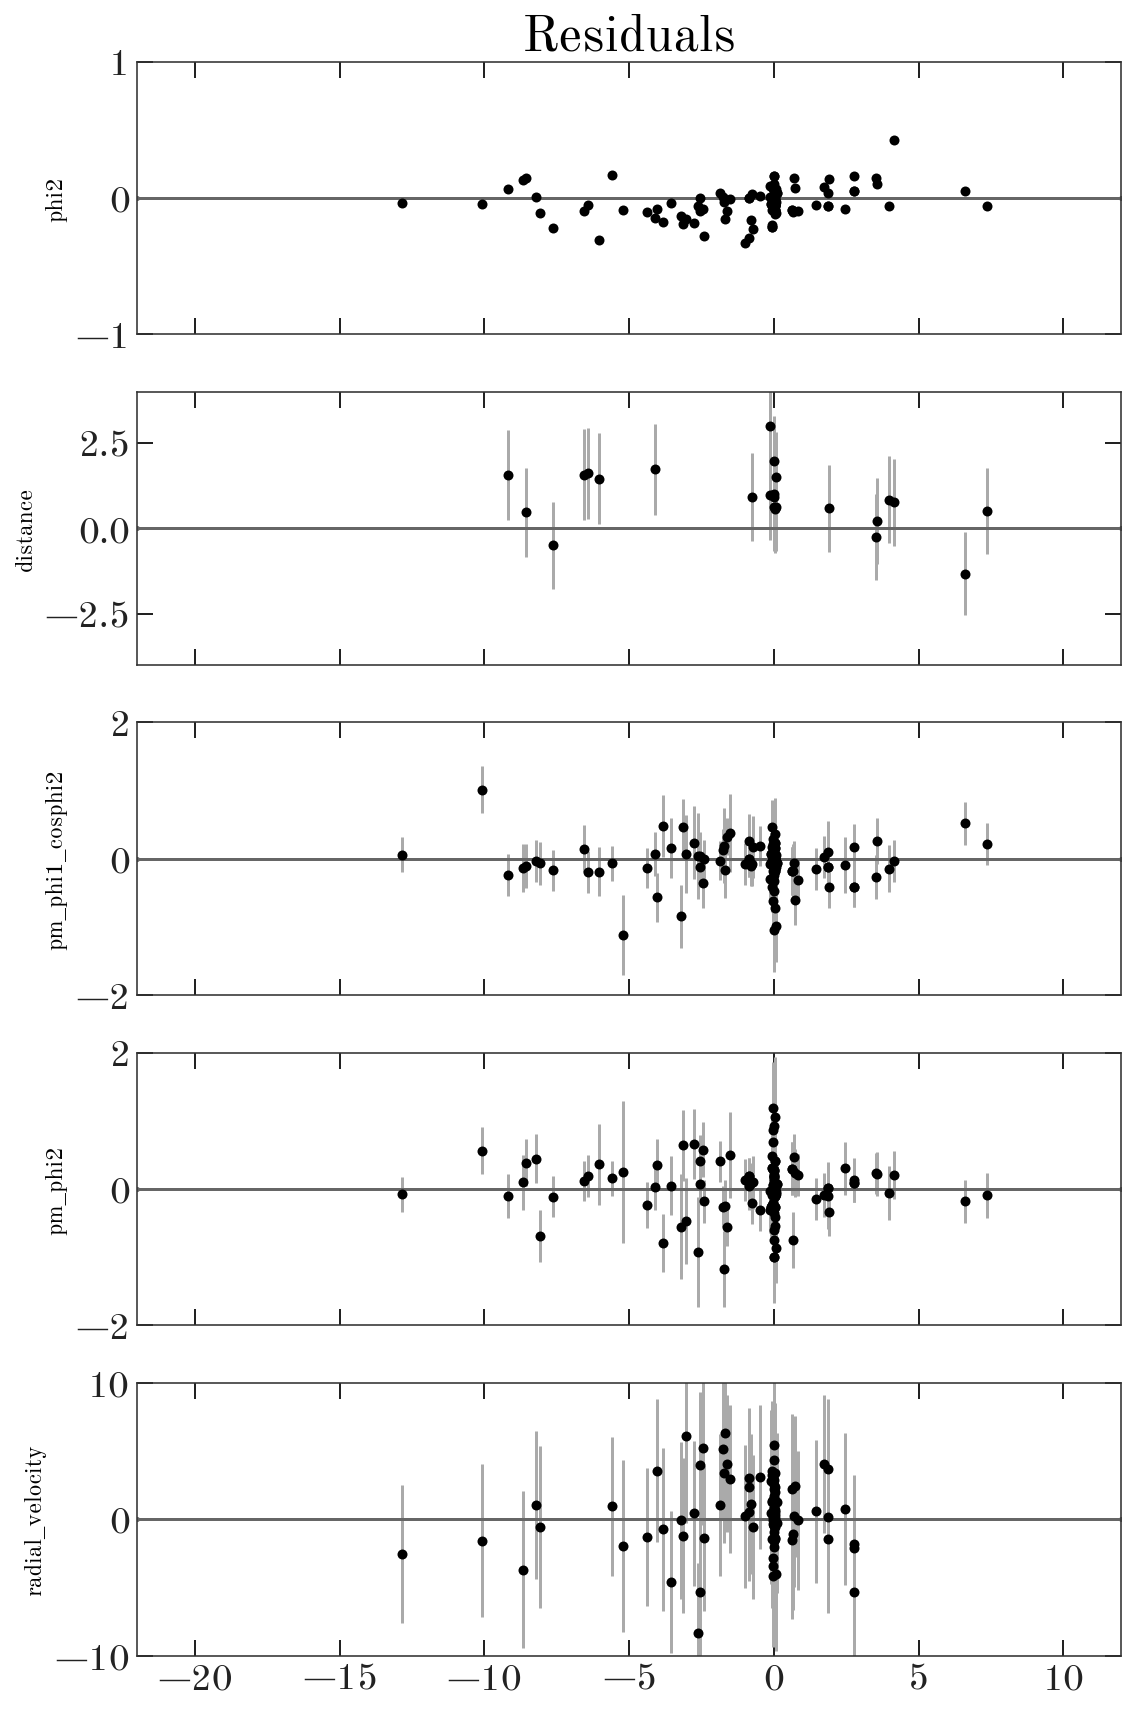

In [62]:
ln_likelihood(res.x, *args, plot=True)

In [63]:
res.x[:5]

array([ 3.64098650e-02,  1.97559733e+01,  3.83442589e+00,  6.92904214e-01,
       -5.58127521e+01])

In [64]:
res.x[5:]

array([27.67710051,  1.11980719, 24.97297352])

In [65]:
# pot = gp.MilkyWayPotential(halo=dict(m=np.exp(25.2), c=1.195))
pot = gp.MilkyWayPotential(halo=dict(m=np.exp(res.x[5]), c=res.x[6]),
                           disk=dict(m=np.exp(res.x[7])))
pot.mass_enclosed([250, 0, 0.])

<Quantity [2.05829367e+12] solMass>

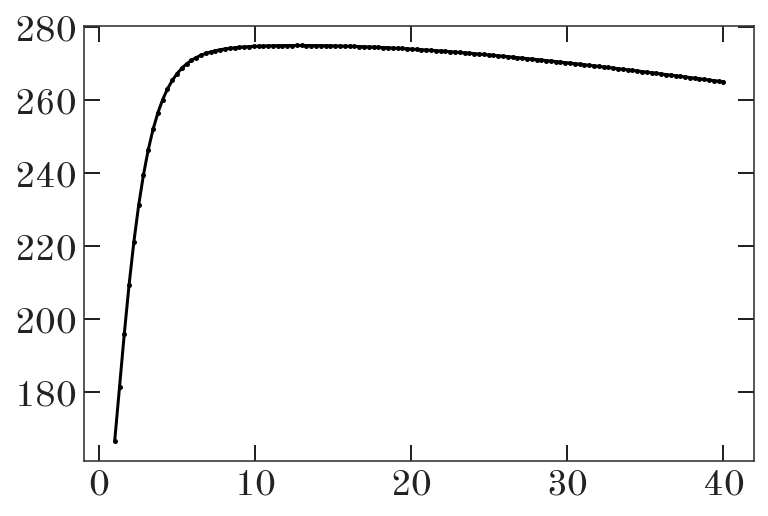

In [66]:
xyz = np.zeros((3, 128))
xyz[0] = np.linspace(1, 40, xyz.shape[1])
plt.plot(xyz[0], pot.circular_velocity(xyz))

---

FUCK it's slow

In [17]:
%load_ext line_profiler

In [18]:
%lprun -f ln_likelihood ln_likelihood(p0, *args, plot=False)

/Users/apricewhelan/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
